In [1]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from download_data import get_price, get_mpd, get_fx
from data_analysis.explore_data import (
    calc_rolling_stat,
    merge_prob_stat,
    rename_stat_df,
    eval_large_change_prob,
    plot_change_scatter,
    prep_regression_stat,
    compare_regressions,
    compare_regression_eval
)

In [2]:
data = get_mpd()
start_date, end_date = data["idt"].min(), data["idt"].max()
print(start_date, end_date)

2006-01-12 00:00:00 2024-01-10 00:00:00


In [3]:
fx = data.loc[data["type"].isin(["fx"])]
fx.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
euro,2011-04-29 00:00:00,3.0,-0.003680,0.062659,-0.322283,0.407039,-0.084137,-0.001107,0.073021,-10.0,0.069296,10.0,0.039502,Euro-USD exchange rate (CME),fx
pound,2011-04-29 00:00:00,3.0,-0.002033,0.048537,-0.326350,0.713841,-0.062991,-0.000362,0.056491,-10.0,0.033302,10.0,0.014766,Pound-USD exchange rate (CME),fx
yen,2011-04-29 00:00:00,3.0,-0.003274,0.059893,0.213295,0.747921,-0.075532,-0.005217,0.071314,-10.0,0.049025,10.0,0.049149,Yen-USD exchange rate (CME),fx


In [4]:
equity = data.loc[data["type"].isin(["equity", "equity_idx"])]
equity.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
bac,2010-01-15 00:00:00,3.0,-0.025140,0.182100,-0.381730,0.851920,-0.253890,-0.016340,0.192720,-20.0,0.148980,20.0,0.093070,Bank of America Corporation,equity
citi,2010-01-15 00:00:00,3.0,-0.027030,0.216670,-0.126270,1.298230,-0.289140,-0.022310,0.226320,-20.0,0.182470,20.0,0.123160,"Citigroup, Inc.",equity
iyr,2010-10-29 00:00:00,3.0,-0.015380,0.136965,-0.948440,1.454774,-0.196561,0.005729,0.135344,-20.0,0.097426,20.0,0.022713,iShares real estate index,equity_idx
sp12m,2007-01-12 00:00:00,12.0,0.034318,0.132616,-1.055814,1.657518,-0.142450,0.057748,0.176416,-20.0,0.061515,20.0,0.056906,"S&P 500, 12-months-out",equity_idx
sp6m,2007-01-12 00:00:00,6.0,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.033820,0.111149,-20.0,0.024242,20.0,0.001915,"S&P 500, 6-months-out",equity_idx


Manually translate name -> stock ticker. SPX is not a tradeable asset, therefore using SPY ETF as approximation.

Also, we can't fetch BAC data with others, hence do it separately.

In [5]:
fx = get_fx(tickers=["GBP", "EUR", "JPY"],
            start_date=start_date,
            end_date=end_date,
            use_cache=False)

In [6]:
close = get_price(tickers=["BAC", "C", "IYR", "SPY"], 
                  start_date=start_date, 
                  end_date=end_date, 
                  use_cache=False)
close = pd.concat([fx, close], axis=1)
close.head()

,EUR,GBP,JPY,BAC,C,IYR,SPY
date,,,,,,,
2006-01-12,0.829958,0.567039,113.974697,31.370887,335.512052,35.586933,91.051694
2006-01-13,0.825866,0.564469,114.457586,31.370887,334.759323,35.013371,90.966856
2006-01-14,0.827567,0.564547,114.464902,NaN,NaN,NaN,NaN
2006-01-15,0.827567,0.564547,114.464902,NaN,NaN,NaN,NaN
2006-01-16,0.825142,0.565478,114.801784,NaN,NaN,NaN,NaN


As mentioned in the methodology paper, all probability are 6-month probability.

In [7]:
stat = calc_rolling_stat(close, n=10)
market_list = ["bac", "citi", "iyr", "sp6m", "sp12m", "euro", "pound", "yen"]
ticker_list = ["BAC", "C", "IYR", "SPY", "SPY", "GBP", "EUR", "JPY"]
stat_rename = rename_stat_df(stat, dict(zip(market_list, ticker_list)))
df = merge_prob_stat(stat_rename, data)
df.head()

maturity_target       mu       sd     skew     kurt  \
market idt                                                               
bac    2010-01-15              3.0 -0.02514  0.18210 -0.38173  0.85192   
       2010-01-29              3.0 -0.02194  0.21265 -0.79513  1.61552   
       2010-02-12              3.0 -0.01699  0.21625 -0.86181  1.83248   
       2010-02-26              3.0 -0.00965  0.17893 -0.70108  1.40641   
       2010-03-15              3.0  0.00006  0.17357 -0.71889  1.63480   

                       p10      p50      p90  lg_change_decr    prDec  \
market idt                                                              
bac    2010-01-15 -0.25389 -0.01634  0.19272           -20.0  0.14898   
       2010-01-29 -0.28826  0.00001  0.21786           -20.0  0.16750   
       2010-02-12 -0.28670  0.00720  0.22358           -20.0  0.16404   
       2010-02-26 -0.23570  0.00776  0.19373           -20.0  0.12882   
       2010-03-15 -0.21657  0.01649  0.19608           -20.0  0.11325   

                   lg_change_incr    prInc                         name  \
market idt                                                                
bac    2010-01-15            20.0  0.09307  Bank of America Corporation   
       2010-01-29            20.0  0.12009  Bank of America Corporation   
       2010-02-12            20.0  0.12713  Bank of America Corporation   
       2010-02-26            20.0  0.09233  Bank of America Corporation   
       2010-03-15            20.0  0.09545  Bank of America Corporation   

                     type       ret       vol   ret_max   ret_min  
market idt                                                         
bac    2010-01-15  equity -0.081992  0.603384  0.014046 -0.087347  
       2010-01-29  equity -0.047210  0.372908  0.027292 -0.047210  
       2010-02-12  equity  0.114934  0.315681  0.114934  0.000000  
       2010-02-26  equity  0.005401  0.139997  0.005401 -0.016950  
       2010-03-15  equity  0.049824  0.254600  0.049824 -0.012408

## 1. Evaluate Large Change
We compare average probability of group with large / negative positive change.

For equity, a higher PrInc / PrDec probability seems to indicate large positive change, despite the definition of PrDec.
For FX, a higher PrInc / PrDec probability seems to indicate large negative change, despite the definition of PrInc.

In [8]:
eval_large_change_prob(df.loc[["bac", "citi", "iyr", "sp6m", "sp12m"]], ub=0.2, lb=-0.2)

prDec                        prInc                   
             -1         0        1        -1         0        1
bac    0.181420  0.092541      NaN  0.131790  0.065185      NaN
citi   0.164573  0.092653  0.22288  0.127497  0.059649  0.16386
iyr    0.166622  0.122045      NaN  0.181460  0.091217      NaN
sp6m   0.194688  0.081031      NaN  0.148831  0.033429      NaN
sp12m  0.232035  0.137745      NaN  0.208727  0.102985      NaN

In [9]:
eval_large_change_prob(df.loc[["euro", "pound", "yen"]], ub=0.1, lb=-0.1)

prDec              prInc         
              0        1         0        1
euro   0.018469  0.04374  0.013611  0.02427
pound  0.023522      NaN  0.014732      NaN
yen    0.019694      NaN  0.026223      NaN

## 2. Scatter Plot

We plot the scatter plot of ret / vol / ret_min / ret_vol -> prInc / prDec.

Both plot and average probability in different actual log return scenario shows:
- prDec / prInc are only positively correlated with log return (correct only in case of prInc)
- SPY has a skewed convex shape, i.e. when no large change log_return, both prDec / prInc are low (this is correct). However, when there is a large change both prInc / prDec has large value. 

Our strategy maybe more related to volatility? i.e. large change or no change
e.g. spread trading but adjusting price band size regularly based on probability estimation

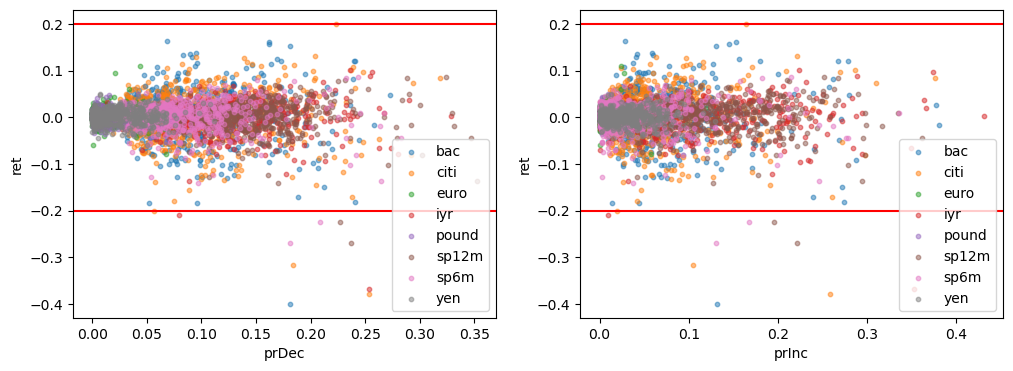

In [10]:
plot_change_scatter(df=df, col="ret", hline_levels=[-0.2, 0.2])

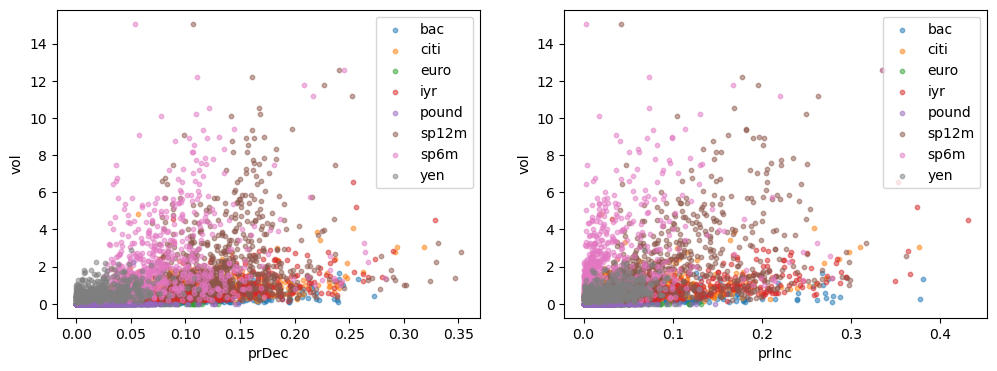

In [11]:
plot_change_scatter(df=df, col="vol")

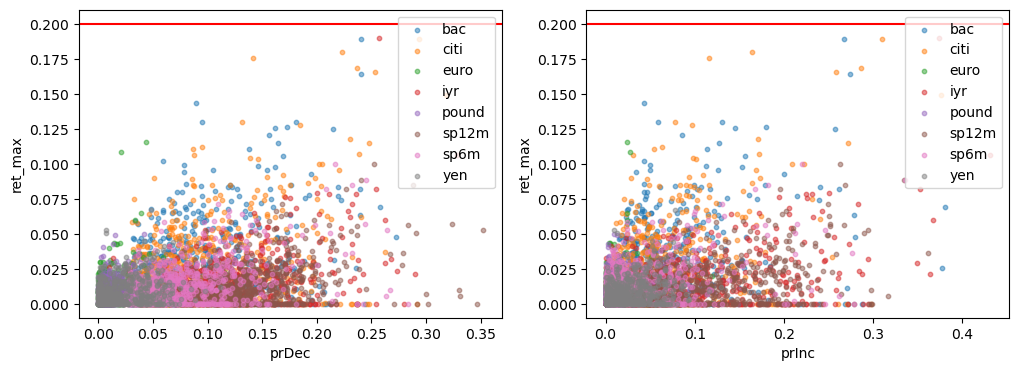

In [12]:
plot_change_scatter(df=df, col="ret_max", hline_levels=[0.2])

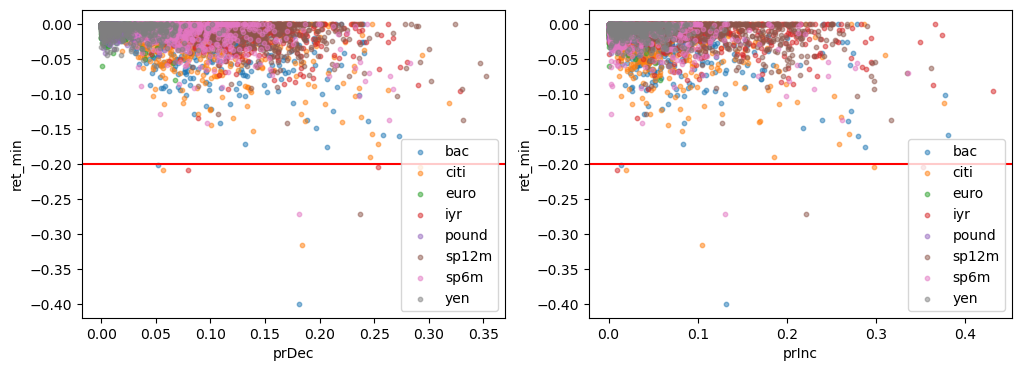

In [13]:
plot_change_scatter(df=df, col="ret_min", hline_levels=[-0.2])

## 3. Time-Series Regression

We ran time-series regression, i.e. SARIMA, GARCH, MarkovRegression with and without probability data and compare the model accuracy.


#### 3.1. Preparation
This part, we made 3 plots:
- ACF / PACF: to evaluate p, q for ARIMA / GARCH model. 
- Seasonal Decompose: to evaluate seasonal trend in a model.
- FFT Power Spectrum: to find most seasonal period.

Findings:
1. ACF shows significance for period <= 6 * 2W (p=6) and PACF shows significant <= 2 * 2W (q=2). However, one problem here is we are using bi-weekly interval data of 6 month returns. Therefore, time-series modeling would constantly peeking into future data.
2.  FFT shows different seasonality for all different series.

/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divi

{'bac': 52.285714285714285,
 'citi': 16.636363636363637,
 'euro': 6.466019417475728,
 'iyr': 115.33333333333334,
 'pound': 8.430379746835444,
 'sp12m': 18.163265306122447,
 'sp6m': 18.163265306122447,
 'yen': 6.054545454545455}

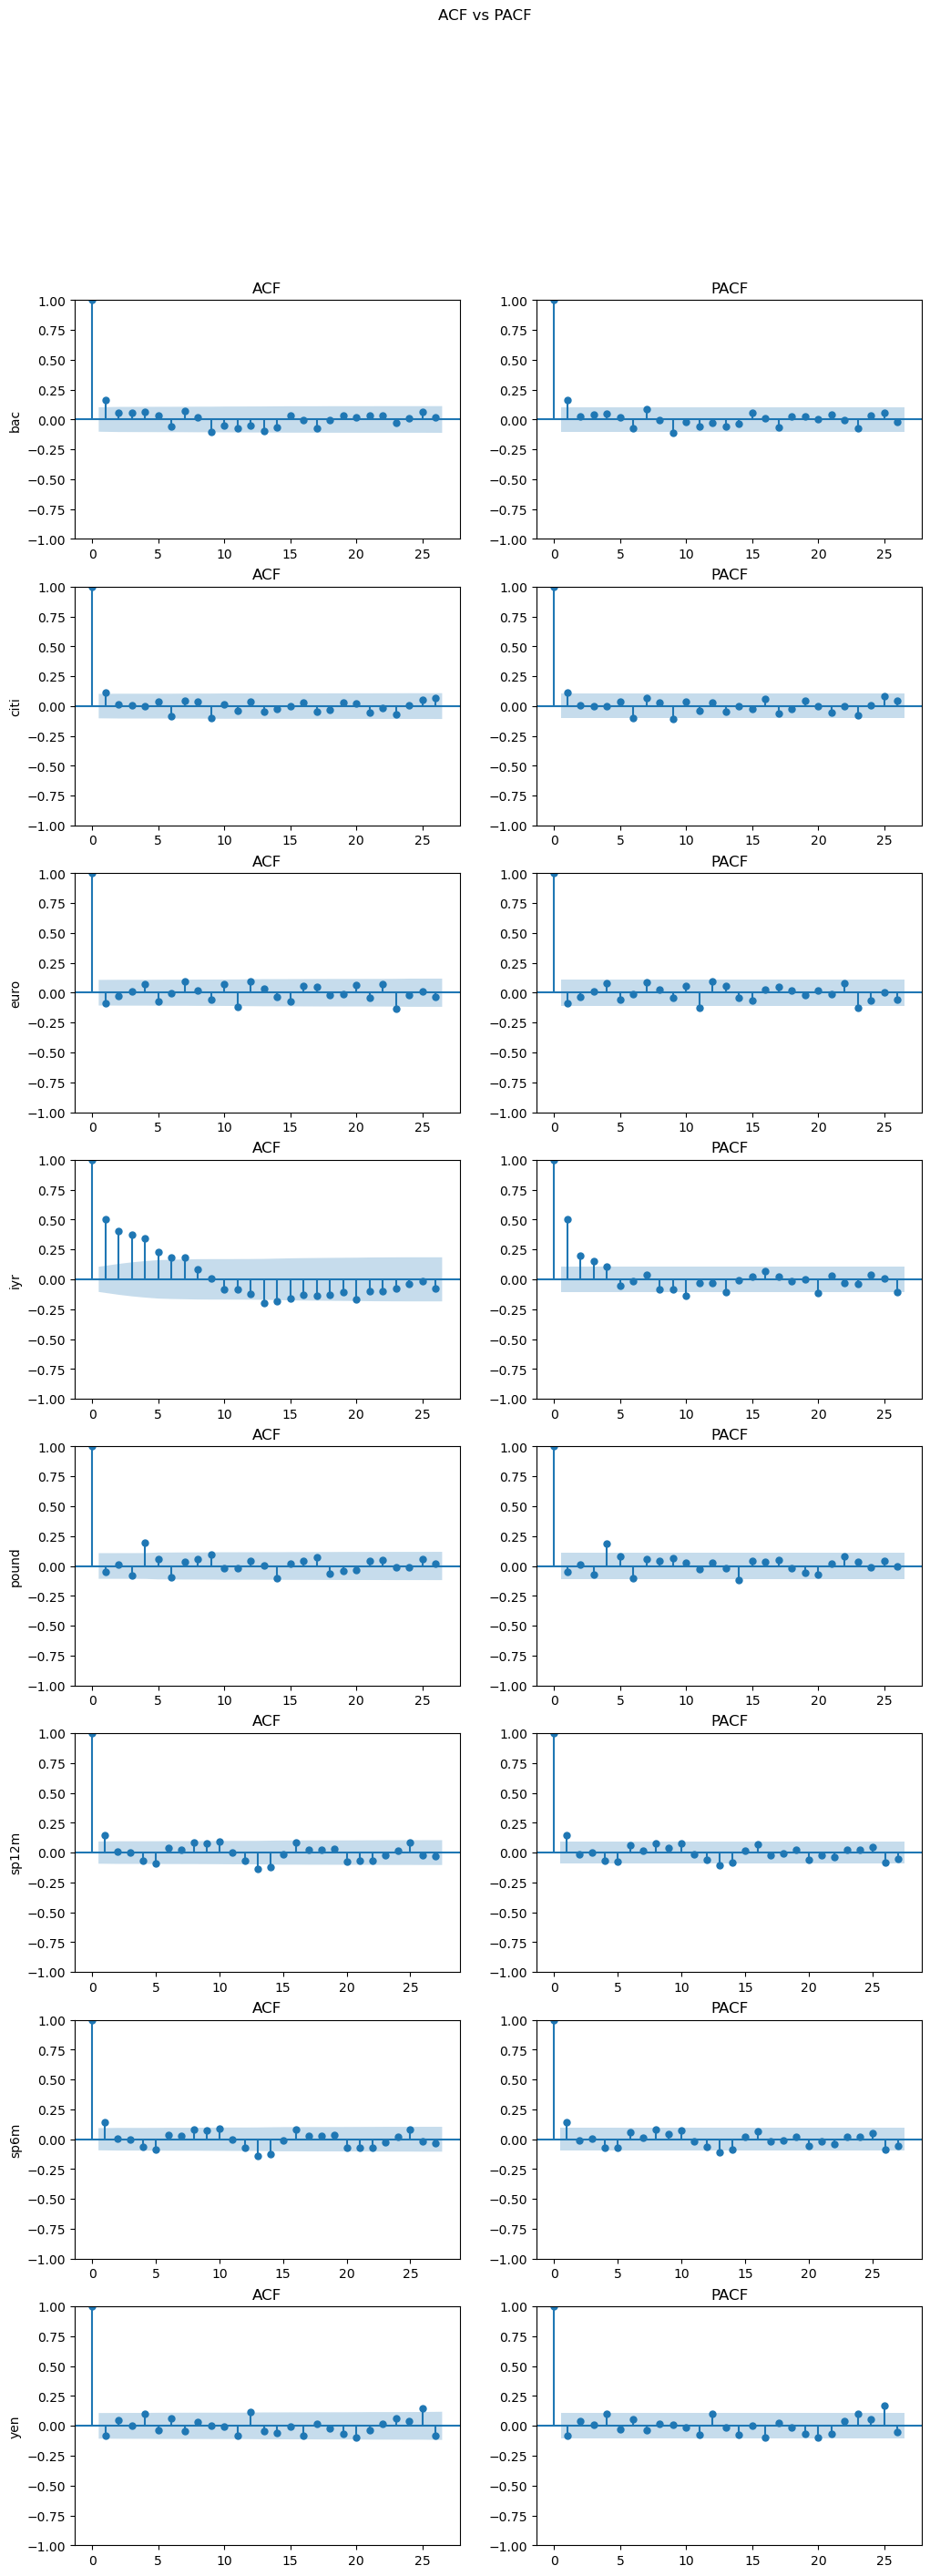

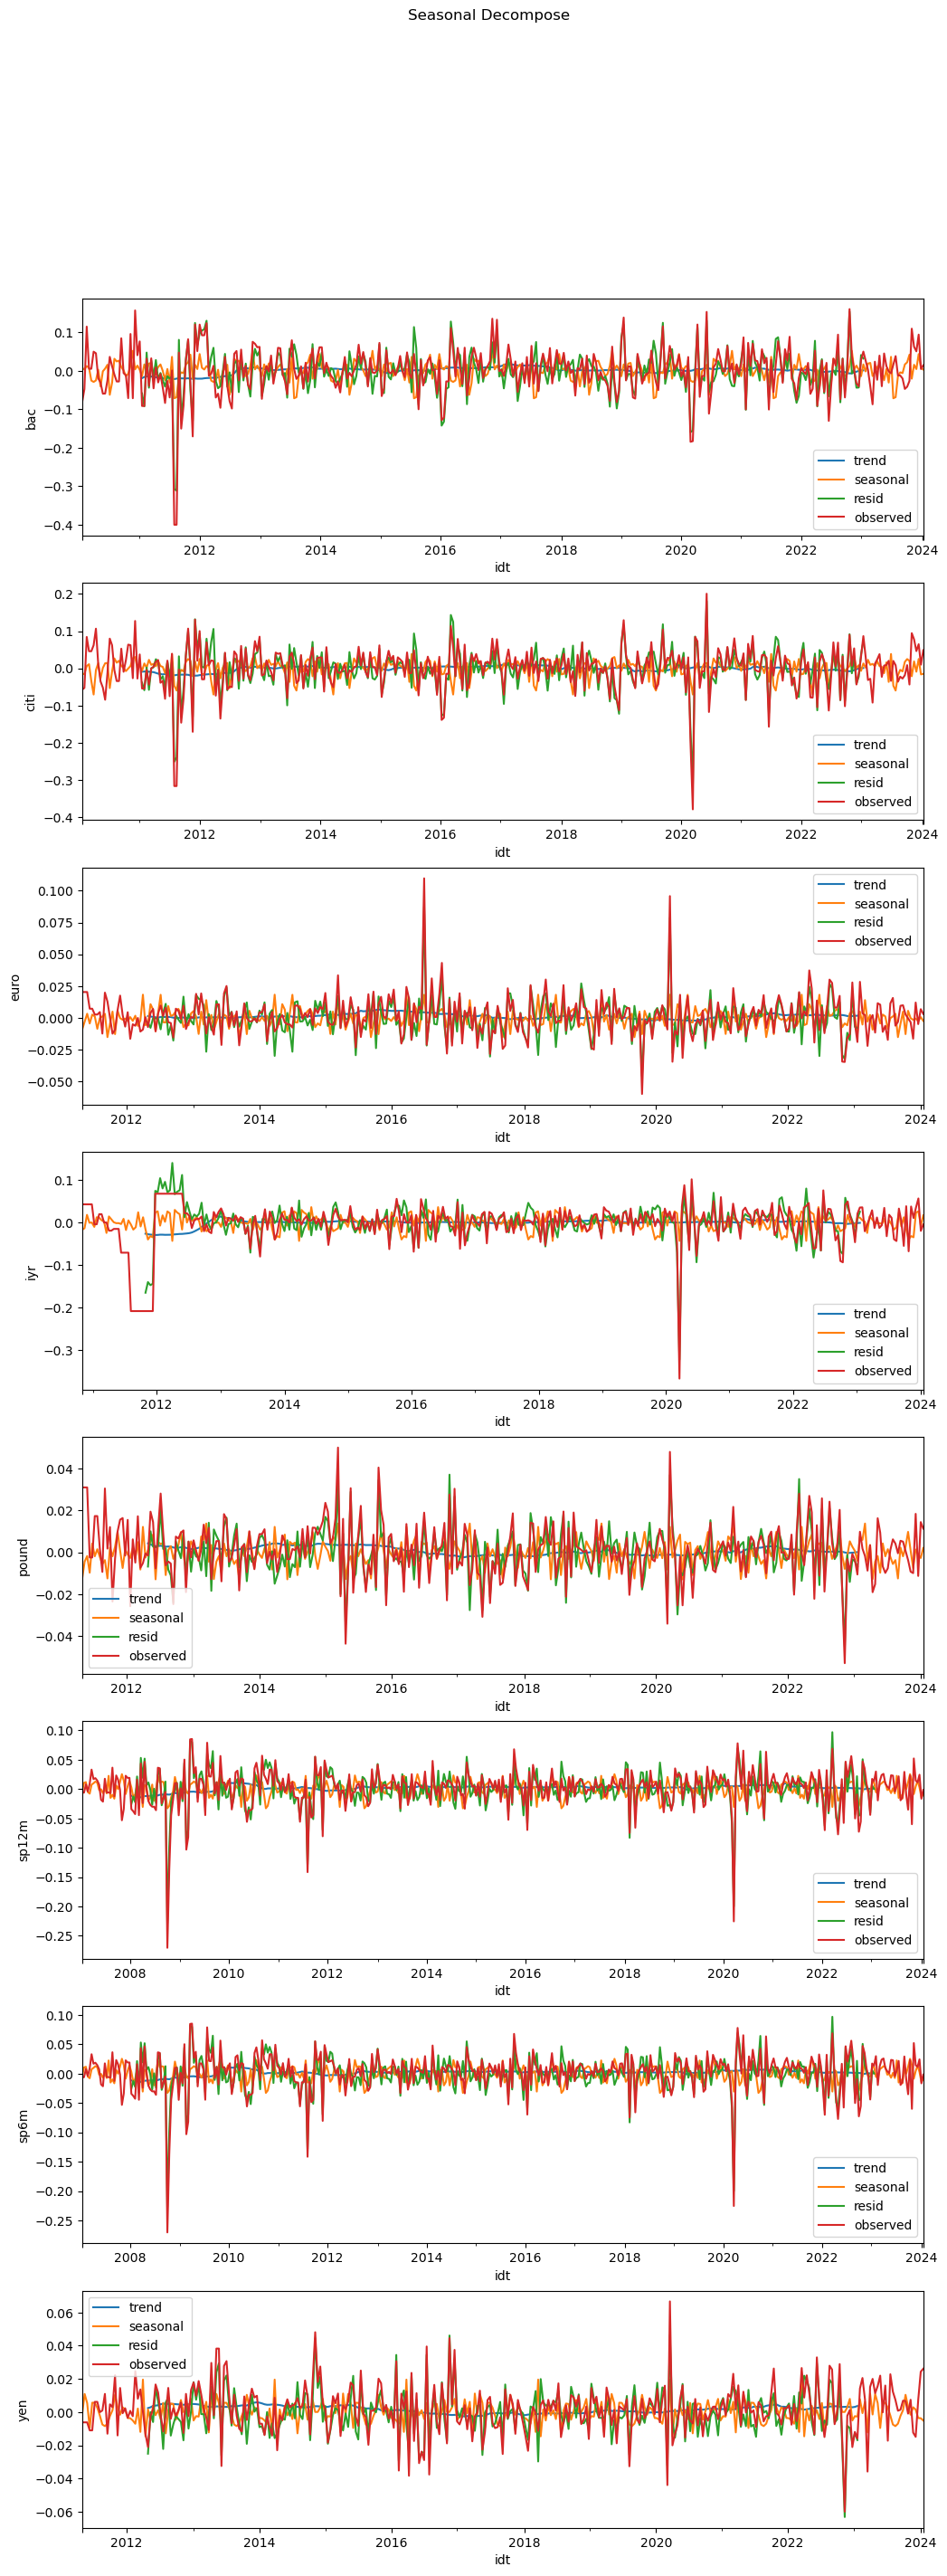

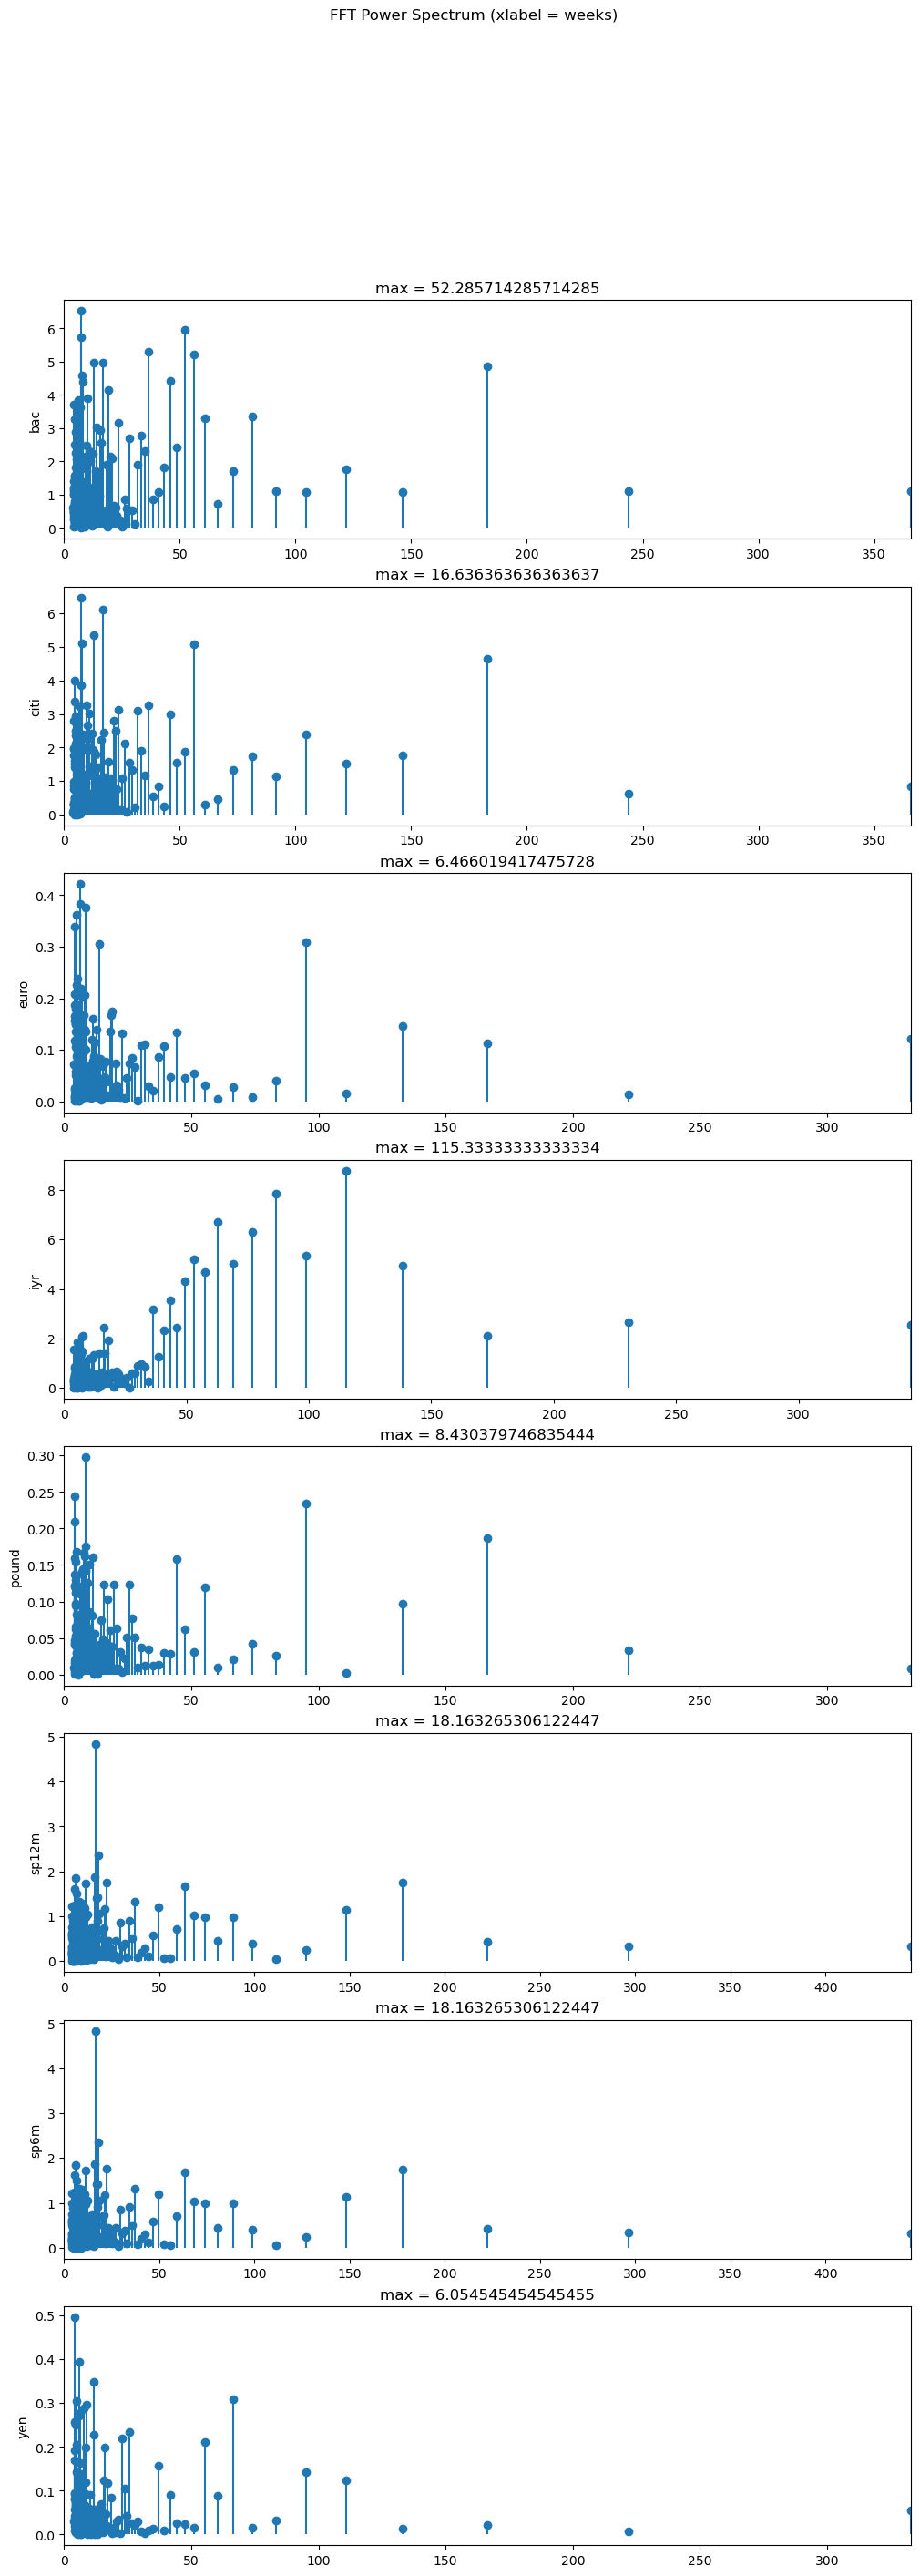

In [14]:
prep_regression_stat(df)

#### 3.2. Compare Regression 
We compare results of with/without probability as exogenous data for follow 4 regression
1. SARIMA
2. GARCH
3. Markov (Change Mean)
4. Markov (Change Volatility)

With a naive model (p=1, q=1), we see with probability tends to outperform by BIC for equity on all models, except for Garch-iyr.

For FX, results are more mixed.
- ARIMA: only yen outperforms with probability
- GARCH: everything outperform
- Markov Mean / Markov Volatility: only pound outperforms. 

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import statsmodels.api as sm
from functools import partial

arima = compare_regressions(df, partial(SARIMAX, order=(1, 0, 1)))
garch = compare_regressions(
    df, partial(arch_model, p=1, q=1, mean='ARX', vol='GARCH'),
    model_ret_name="y", model_prob_name="x",
)
markov = compare_regressions(df, partial(sm.tsa.MarkovRegression, k_regimes=3))
markov_vol = compare_regressions(df, partial(sm.tsa.MarkovRegression, k_regimes=3,
                                             switching_variance=True))

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38932D+00    |proj g|=  1.04743D-01

At iterate    5    f= -1.38933D+00    |proj g|=  3.30101D-02

At iterate   10    f= -1.38934D+00    |proj g|=  2.46062D-03

At iterate   15    f= -1.38934D+00    |proj g|=  2.51945D-02

At iterate   20    f= -1.38940D+00    |proj g|=  6.30272D-03

At iterate   25    f= -1.38943D+00    |proj g|=  3.88198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     42      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41694D+00    |proj g|=  1.78605D-02

At iterate    5    f= -1.41696D+00    |proj g|=  1.61200D-03

At iterate   10    f= -1.41697D+00    |proj g|=  2.54031D-02

At iterate   15    f= -1.41697D+00    |proj g|=  2.80585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   2.637D-04  -1.417D+00
  F =  -1.4169749750782286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     58      2     0     0   5.347D-03  -1.732D+00
  F =  -1.7318589281634094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72995D+00    |proj g|=  2.95659D-01

At iterate    5    f= -1.73010D+00    |proj g|=  3.89617D-01

At iterate   10    f= -1.73274D+00    |proj g|=  1.53577D-01

At iterate   15    f= -1.73296D+00    |proj g|=  1.97381D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.79702D+00    |proj g|=  4.00599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     19      1     0     0   1.293D-02  -2.797D+00
  F =  -2.7970264388040182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.80709D+00    |proj g|=  4.54801D-01

At iterate    5    f= -2.80710D+00    |proj g|=  2.50750D-02

At iterate   10    f= -2.80710D+00    |proj g|=  1.73007D-01

At iter

 This problem is unconstrained.
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003744. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003734. Parameter
estimation work

Iteration:      2,   Func. Count:     17,   Neg. LLF: -245.03905655282716
Iteration:      3,   Func. Count:     26,   Neg. LLF: -461.86175749038443
Iteration:      4,   Func. Count:     32,   Neg. LLF: -500.50441076960885
Iteration:      5,   Func. Count:     39,   Neg. LLF: -554.9885973085933
Iteration:      6,   Func. Count:     45,   Neg. LLF: -555.1940079706976
Iteration:      7,   Func. Count:     50,   Neg. LLF: -555.1944412872471
Iteration:      8,   Func. Count:     55,   Neg. LLF: -555.1944466993318
Iteration:      9,   Func. Count:     59,   Neg. LLF: -555.1944466993614
Optimization terminated successfully    (Exit mode 0)
            Current function value: -555.1944466993318
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      8,   Neg. LLF: 737442.7380446664
Iteration:      2,   Func. Count:     20,   Neg. LLF: 501.2896489981877
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2683726

/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/a

In [16]:
compare_regression_eval(arima, "bic").loc[market_list]

,with,without,diff
bac,-987.586795,-999.354069,11.767273
citi,-1007.712515,-1019.491183,11.778668
iyr,-1170.360668,-1180.907062,10.546394
sp6m,-1749.494501,-1759.738207,10.243706
sp12m,-1748.296111,-1759.738207,11.442096
euro,-1804.513811,-1811.037270,6.523459
pound,-1918.285524,-1920.304591,2.019067
yen,-1842.348669,-1845.395181,3.046512


In [17]:
compare_regression_eval(garch, "bic").loc[market_list]

,with,without,diff
bac,-1031.383366,-1042.393549,11.010183
citi,-1078.708470,-1086.778360,8.069890
iyr,-1247.552341,-1343.710722,96.158382
sp6m,-1809.939125,-1816.073477,6.134352
sp12m,-1810.222706,-1816.073477,5.850771
euro,-1804.278725,-1812.283288,8.004564
pound,-1942.320730,-1947.000127,4.679396
yen,-1876.587670,-1884.690213,8.102543


In [18]:
compare_regression_eval(markov, "bic").loc[market_list]

,with,without,diff
bac,-1054.274594,-1033.243071,-21.031522
citi,-1091.122602,-973.412627,-117.709976
iyr,-1368.462062,-1357.117957,-11.344105
sp6m,-1898.349726,-1728.794440,-169.555286
sp12m,-1914.710967,-1728.794440,-185.916527
euro,-1839.099612,-1860.716245,21.616634
pound,-1896.939583,-1880.419031,-16.520552
yen,-1834.077908,-1846.854565,12.776657


In [19]:
compare_regression_eval(markov_vol, "bic").loc[market_list]

,with,without,diff
bac,-1044.456818,-1147.351350,102.894532
citi,-1073.699924,-1087.365895,13.665971
iyr,-1337.050831,-1342.742072,5.691242
sp6m,-1920.277687,-1921.514824,1.237137
sp12m,-1903.889228,-1921.514824,17.625596
euro,-1840.078470,-1844.986349,4.907879
pound,-1894.039305,-1918.237432,24.198127
yen,-1845.012130,-1861.726965,16.714835
